# Basic Lhotse Workflow using AIStore and GetBatch Functionality

This notebook shows how to write a dataloading pipeline for ASR using mini LibriSpeech dataset and [AIStore](https://aistore.nvidia.com/): a lightweight distributed storage
system for AI.

We upload audio files into a seperate tar object for every speaker identifier to AIStore using the AIStore Python SDK. Then, we modify the the CutSets designed for local filesystem storage to access the AIStore objects instead.

Then, with the `BatchMemoryLoader` Lhotse class, we can use the AIStore batch request API to load the entire `CutSet` into memory from AIStore all from one request to the cluster.

We don't pre-compute the features here for simplicity; in real workflows you might want to precompute them if your disks are slow to read. We will demonstrate that in a separate tutorial.

In [1]:
import os
import sys
from pathlib import Path
import tarfile
from torch.utils.data import DataLoader

sys.path.append("/home/smanoli/go_projects/src/github.com/NVIDIA/aistore/python")
from aistore import Client

sys.path.append("/home/smanoli/lhotse")
from lhotse import (
    CutSet, 
    Fbank, 
    RecordingSet, 
    SupervisionSet, 
    Recording
)

from lhotse.dataset import (
    BucketingSampler,
    K2SpeechRecognitionDataset,
    OnTheFlyFeatures,
    PerturbSpeed,
    PerturbVolume,
    SpecAugment,
)

from lhotse.recipes import (
    download_librispeech,
    prepare_librispeech,
)

from lhotse.cut.batch_io import BatchMemoryLoader

/drive/envs/lhotse/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = Path("data")
num_jobs = os.cpu_count() - 1

# Download data locally
libri_variant = "mini_librispeech"
libri_root = download_librispeech(root_dir, dataset_parts=libri_variant)
libri = prepare_librispeech(
    libri_root, dataset_parts=libri_variant, output_dir=root_dir, num_jobs=num_jobs
)

Dataset parts: 100%|██████████| 2/2 [00:00<00:00, 23629.88it/s]


In [3]:
# Assumes we have an AIS cluster configured via env var
AIS_ENDPOINT = os.environ.get("AIS_ENDPOINT")

# If not, default to local cluster and update env var
if not AIS_ENDPOINT:
    AIS_ENDPOINT = os.environ["AIS_ENDPOINT"] = "http://localhost:8080"

# Initialize AIStore client
client = Client(AIS_ENDPOINT)

# Get the buckets
dev_bucket = client.bucket("dev-clean-2").create(exist_ok=True)
train_bucket = bucket = client.bucket("train-clean-5").create(exist_ok=True)

In [4]:
# Audio file extensions to look for
audio_extensions = {'.flac', '.mp3', '.wav', '.m4a', '.aac', '.ogg', '.wma'}

output_dir = os.path.join(root_dir, "temporary")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

tar_files_created = []

# Walk through the directory structure
for root, dirs, files in os.walk(root_dir):
    # Check if current directory has audio files
    audio_files = [f for f in files if any(f.lower().endswith(ext) for ext in audio_extensions)]
    
    if audio_files:
        # Get the path components
        rel_path = os.path.relpath(root, root_dir)
        path_parts = rel_path.split(os.sep)
        
        # Skip if it's the root directory itself
        if rel_path == '.':
            continue
        
        # Create tar filename from path components
        if len(path_parts) >= 2:
            # For paths like "84/121550", create "84_121550.tar"
            tar_name = '_'.join(path_parts) + '.tar'
        else:
            # For single level paths
            tar_name = path_parts[0] + '.tar'
        
        tar_path = os.path.join(output_dir, tar_name)
        
        print(f"Creating {tar_name} with {len(audio_files)} audio files...")
        
        # Create tar file with all files from this directory
        with tarfile.open(tar_path, 'w') as tar:
            for file in files:  # Add all files, not just audio
                file_path = os.path.join(root, file)
                # Use just the filename in the archive (no directory structure)
                tar.add(file_path, arcname=file)
        
        # Save tar path
        tar_files_created.append(tar_path)

        print(f"✓ Created: {tar_name}")

Creating LibriSpeech_dev-clean-2_5694_64038.tar with 26 audio files...
✓ Created: LibriSpeech_dev-clean-2_5694_64038.tar
Creating LibriSpeech_dev-clean-2_6319_57405.tar with 13 audio files...
✓ Created: LibriSpeech_dev-clean-2_6319_57405.tar
Creating LibriSpeech_dev-clean-2_1993_147964.tar with 11 audio files...
✓ Created: LibriSpeech_dev-clean-2_1993_147964.tar
Creating LibriSpeech_dev-clean-2_8842_304647.tar with 14 audio files...
✓ Created: LibriSpeech_dev-clean-2_8842_304647.tar
Creating LibriSpeech_dev-clean-2_2803_161169.tar with 18 audio files...
✓ Created: LibriSpeech_dev-clean-2_2803_161169.tar
Creating LibriSpeech_dev-clean-2_2803_154320.tar with 15 audio files...
✓ Created: LibriSpeech_dev-clean-2_2803_154320.tar
Creating LibriSpeech_dev-clean-2_3000_15664.tar with 47 audio files...
✓ Created: LibriSpeech_dev-clean-2_3000_15664.tar
Creating LibriSpeech_dev-clean-2_777_126732.tar with 82 audio files...
✓ Created: LibriSpeech_dev-clean-2_777_126732.tar
Creating LibriSpeech_dev

✓ Created: LibriSpeech_dev-clean-2_3536_23268.tar
Creating LibriSpeech_dev-clean-2_8297_275156.tar with 14 audio files...
✓ Created: LibriSpeech_dev-clean-2_8297_275156.tar
Creating LibriSpeech_dev-clean-2_1462_170145.tar with 23 audio files...
✓ Created: LibriSpeech_dev-clean-2_1462_170145.tar
Creating LibriSpeech_dev-clean-2_1462_170142.tar with 43 audio files...
✓ Created: LibriSpeech_dev-clean-2_1462_170142.tar
Creating LibriSpeech_dev-clean-2_6241_61943.tar with 28 audio files...
✓ Created: LibriSpeech_dev-clean-2_6241_61943.tar
Creating LibriSpeech_dev-clean-2_6241_61946.tar with 24 audio files...
✓ Created: LibriSpeech_dev-clean-2_6241_61946.tar
Creating LibriSpeech_dev-clean-2_7976_110523.tar with 22 audio files...
✓ Created: LibriSpeech_dev-clean-2_7976_110523.tar
Creating LibriSpeech_dev-clean-2_251_136532.tar with 24 audio files...
✓ Created: LibriSpeech_dev-clean-2_251_136532.tar
Creating LibriSpeech_dev-clean-2_251_118436.tar with 24 audio files...
✓ Created: LibriSpeech_d

In [5]:
# Upload all tar files to AIStore and delete locally
for i, tar_path in enumerate(tar_files_created, 1):
    tar_name = os.path.basename(tar_path)
    

    if "dev" in tar_name:
        bucket = dev_bucket
    else:
        bucket = train_bucket

    try:
        bucket.object(tar_name).get_writer().put_file(tar_path)
        print(f"[{i}/{len(tar_files_created)}] ✓ Uploaded: {tar_name}")
        
        # Delete the local tar file after successful upload
        os.remove(tar_path)
        print(f"[{i}/{len(tar_files_created)}] 🗑️ Deleted: {tar_name}")
        
    except Exception as e:
        print(f"[{i}/{len(tar_files_created)}] ✗ Failed to upload {tar_name}: {e}")

os.rmdir(output_dir)

print("\nCompleted! All tar files have been uploaded and any artifacts have been deleted locally.")

[1/67] ✓ Uploaded: LibriSpeech_dev-clean-2_5694_64038.tar
[1/67] 🗑️ Deleted: LibriSpeech_dev-clean-2_5694_64038.tar
[2/67] ✓ Uploaded: LibriSpeech_dev-clean-2_6319_57405.tar
[2/67] 🗑️ Deleted: LibriSpeech_dev-clean-2_6319_57405.tar
[3/67] ✓ Uploaded: LibriSpeech_dev-clean-2_1993_147964.tar
[3/67] 🗑️ Deleted: LibriSpeech_dev-clean-2_1993_147964.tar


[4/67] ✓ Uploaded: LibriSpeech_dev-clean-2_8842_304647.tar
[4/67] 🗑️ Deleted: LibriSpeech_dev-clean-2_8842_304647.tar
[5/67] ✓ Uploaded: LibriSpeech_dev-clean-2_2803_161169.tar
[5/67] 🗑️ Deleted: LibriSpeech_dev-clean-2_2803_161169.tar
[6/67] ✓ Uploaded: LibriSpeech_dev-clean-2_2803_154320.tar
[6/67] 🗑️ Deleted: LibriSpeech_dev-clean-2_2803_154320.tar
[7/67] ✓ Uploaded: LibriSpeech_dev-clean-2_3000_15664.tar
[7/67] 🗑️ Deleted: LibriSpeech_dev-clean-2_3000_15664.tar
[8/67] ✓ Uploaded: LibriSpeech_dev-clean-2_777_126732.tar
[8/67] 🗑️ Deleted: LibriSpeech_dev-clean-2_777_126732.tar
[9/67] ✓ Uploaded: LibriSpeech_dev-clean-2_5338_24640.tar
[9/67] 🗑️ Deleted: LibriSpeech_dev-clean-2_5338_24640.tar
[10/67] ✓ Uploaded: LibriSpeech_dev-clean-2_5338_284437.tar
[10/67] 🗑️ Deleted: LibriSpeech_dev-clean-2_5338_284437.tar
[11/67] ✓ Uploaded: LibriSpeech_dev-clean-2_6295_244435.tar
[11/67] 🗑️ Deleted: LibriSpeech_dev-clean-2_6295_244435.tar
[12/67] ✓ Uploaded: LibriSpeech_dev-clean-2_84_121550.tar


In [6]:
dev_recordings = RecordingSet.from_file("data/librispeech_recordings_dev-clean-2.jsonl.gz")
dev_supervisions = SupervisionSet.from_file("data/librispeech_supervisions_dev-clean-2.jsonl.gz")

# Load dev cut (metadata only)
dev_cuts = CutSet.from_manifests(recordings=dev_recordings, supervisions=dev_supervisions)

In [7]:
# function to parse audio path and convert to our aistore path
def parse_audio_path(audio_path: str):
    """Parse audio path to AIStore parameters."""
    if "../data/LibriSpeech/" in audio_path:
        relative_path = audio_path.split("data/LibriSpeech/", 1)[1]
    else:
        relative_path = audio_path
    
    # relative_path: "dev-clean-2/5694/64038/5694-64038-0000.flac"

    intermediates = relative_path.split('/')[2:-1]
    tar_filename = "LibriSpeech"

    for inter in intermediates:
        tar_filename = f"{tar_filename}_{inter}"

    tar_filename = f"{tar_filename}.tar"

    archpath = relative_path.split('/')[-1]
    
    if "dev-clean-2" in audio_path:
        bucket_name = "dev-clean-2"
    else :
        bucket_name = "train-clean-5"
    
    return bucket_name, tar_filename, archpath

In [8]:
# modify the source to be harcoded url (ais path)
for cut in dev_cuts:
    for attr_name, manifest in cut.iter_data():
        if isinstance(manifest, Recording):
            for source in manifest.sources:

                assert source.type == "file"

                path = source.source
                bucket_name, tar_filename, archpath = parse_audio_path(path)
                source.source = f"ais://{bucket_name}/{tar_filename}/{archpath}"
                source.type = "url"

In [9]:
# Create BatchMemoryLoader
batch_mem_load = BatchMemoryLoader(fault_tolerant=False)

# Load entire dev cutset into memory from AIStore
mem_dev_cuts = batch_mem_load(dev_cuts)

In [10]:
# Now when you call cut.load_audio(), it will fetch from AIStore
for i, cut in enumerate(mem_dev_cuts):

    num_channels, num_samples = cut.load_audio().shape

    sample_rate = cut.recording.sampling_rate
    expected_samples = int(cut.duration * sample_rate)

    assert abs(num_samples - expected_samples) <= sample_rate * 0.01

    print(f"cut_id: {cut.id}, channels: {num_channels}, samples: {num_samples}")

print(f"Total number of dev cuts processed: {i + 1}")

cut_id: 5694-64038-0000-0, channels: 1, samples: 41520
cut_id: 5694-64038-0001-1, channels: 1, samples: 58400
cut_id: 5694-64038-0002-2, channels: 1, samples: 140320
cut_id: 5694-64038-0003-3, channels: 1, samples: 109120
cut_id: 5694-64038-0004-4, channels: 1, samples: 153280
cut_id: 5694-64038-0005-5, channels: 1, samples: 75200
cut_id: 5694-64038-0006-6, channels: 1, samples: 40400
cut_id: 5694-64038-0007-7, channels: 1, samples: 37920
cut_id: 5694-64038-0008-8, channels: 1, samples: 31200
cut_id: 5694-64038-0009-9, channels: 1, samples: 38160
cut_id: 5694-64038-0010-10, channels: 1, samples: 150080
cut_id: 5694-64038-0011-11, channels: 1, samples: 47920
cut_id: 5694-64038-0012-12, channels: 1, samples: 44880
cut_id: 5694-64038-0013-13, channels: 1, samples: 52880
cut_id: 5694-64038-0014-14, channels: 1, samples: 68640
cut_id: 5694-64038-0015-15, channels: 1, samples: 108320
cut_id: 5694-64038-0016-16, channels: 1, samples: 41360
cut_id: 5694-64038-0017-17, channels: 1, samples: 245

In [11]:
train_recordings = RecordingSet.from_file("data/librispeech_recordings_train-clean-5.jsonl.gz")
train_supervisions = SupervisionSet.from_file("data/librispeech_supervisions_train-clean-5.jsonl.gz")

# Load dev cut (metadata only)
train_cuts = CutSet.from_manifests(recordings=train_recordings, supervisions=train_supervisions)

In [12]:
# modify the source to be harcoded url (ais path)
for cut in train_cuts:
    for attr_name, manifest in cut.iter_data():
        if isinstance(manifest, Recording):
            for source in manifest.sources:

                assert source.type == "file"

                path = source.source
                bucket_name, tar_filename, archpath = parse_audio_path(path)
                source.source = f"ais://{bucket_name}/{tar_filename}/{archpath}"
                source.type = "url"

In [13]:
# Load entire train cutset into memory from AIStore
mem_train_cuts = batch_mem_load(train_cuts)

In [14]:
# Training dataset has augmentations
train_sampler = BucketingSampler(
    mem_train_cuts,
    shuffle=True,
    max_duration=100.0,
    num_buckets=10,
)

train_dataset = K2SpeechRecognitionDataset(
    cut_transforms=[
        PerturbSpeed(factors=[0.9, 1.1], p=2 / 3),
        PerturbVolume(scale_low=0.125, scale_high=2.0, p=0.5),
    ],
    input_transforms=[
        SpecAugment(),  # default configuration is well-tuned
    ],
    input_strategy=OnTheFlyFeatures(Fbank()),
)

train_dloader = DataLoader(
    train_dataset,
    sampler=train_sampler,
    batch_size=None,
    num_workers=0,  # For faster dataloading, use num_workers > 1
)

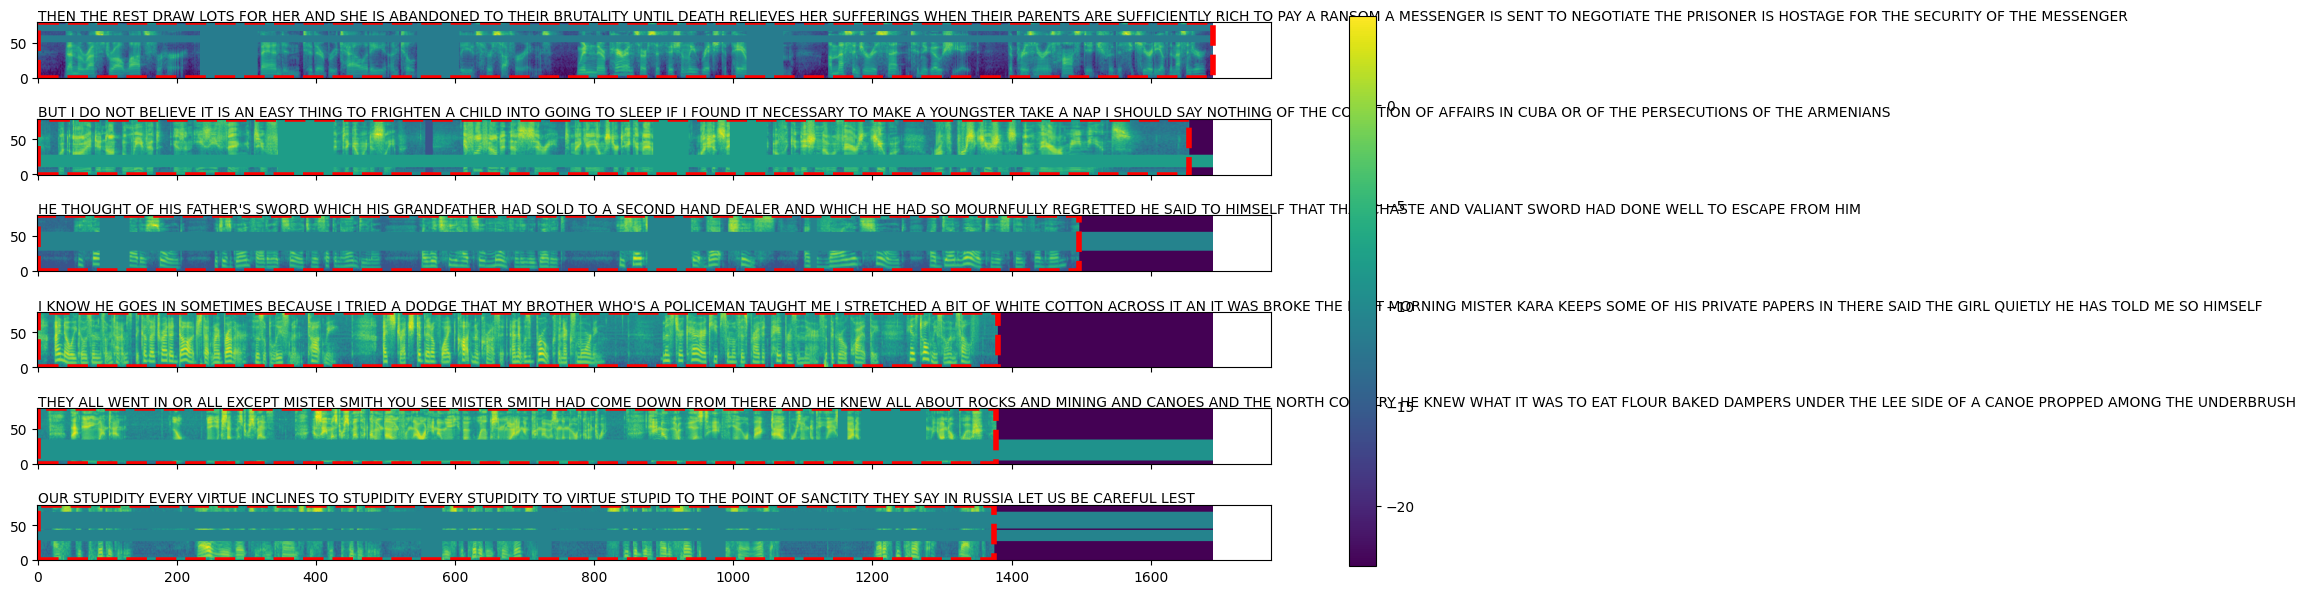

In [15]:
from lhotse.dataset.vis import plot_batch

for batch in train_dloader:
    plot_batch(batch)
    break